# Jupyter Example
## LAMMPS: Neb/in.neb.sivac
Reference: https://github.com/lammps/lammps/blob/master/examples/neb/in.neb.sivac  
Requied files: initial.sivac, final.sivac  
Description: NEB simulation of vacancy hopping in silicon crystal

In [1]:
import os
import ipyparallel as ipp
rc = ipp.Client(profile='mpi')
view = rc[:]
print("Total number of MPI tasks =",len(view))

Total number of MPI tasks = 48


In [2]:
# Set file paths
task_dir=os.getcwd()+'/'
data_init=task_dir+"initial.sivac"
data_final=task_dir+"final.sivac"
infile=task_dir+"in.neb"
logfile=task_dir+"log.lammps"

# Create an empty input file (required by LAMMPS)
file=open(infile,'w')
file.close()

In [3]:
view['task_dir']=task_dir
view['logfile']=logfile
view['infile']=infile
view['data_init']=data_init
view['data_final']=data_final

## Initialize LAMMPS

In [4]:
%%capture
%%px
from mpi4py import MPI
from lammps import PyLammps
# Use 13 images with 2 MPI tasks per image
L = PyLammps(cmdargs=["-partition","24x2","-in",infile,"-log",logfile,"-plog","none","-pscreen","none"])

## Initial minimization

In [5]:
%%time
%%px

L.units("metal")

L.atom_style("atomic")
L.atom_modify("map array sort 0 0.0")
L.boundary("p p p")

# coordination number cutoff

L.variable("r equal 2.835")

# diamond unit cell

L.variable("a equal 5.431")

lattice_1="a1 1.0 0.0 0.0"
lattice_2="a2 0.0 1.0 0.0"
lattice_3="a3 0.0 0.0 1.0"
basis_1="basis 0.0 0.0 0.0"
basis_2="basis 0.0 0.5 0.5"
basis_3="basis 0.5 0.0 0.5"
basis_4="basis 0.5 0.5 0.0"
basis_5="basis 0.25 0.25 0.25"
basis_6="basis 0.25 0.75 0.75"
basis_7="basis 0.75 0.25 0.75"
basis_8="basis 0.75 0.75 0.25"

L.lattice("custom $a",lattice_1,lattice_2,lattice_3,basis_1,basis_2,basis_3,basis_4,basis_5,basis_6,basis_7,basis_8)

L.region("myreg block 0 4 0 4 0 4")

L.read_data(data_init)

# make a vacancy

L.group("Si type 1") 
L.group("del id 300")
L.delete_atoms("group del compress no")
L.group("vacneigh id 174 175 301 304 306 331 337")

# choose potential

L.pair_style("sw")
L.pair_coeff("* *",task_dir+"Si.sw","Si")

# set up neb run

L.variable("u uloop 50 pad")

# initial minimization to relax surface

L.minimize("1.0e-6 1.0e-4 1000 10000")
L.reset_timestep("0")

CPU times: user 105 ms, sys: 7.98 ms, total: 113 ms
Wall time: 108 ms


## Nudged-elastic band calculation

In [6]:
%%time
%%px

L.fix("1 all neb 1.0")

L.thermo(100)

# run NEB

L.timestep("0.01")
L.min_style("quickmin")
L.neb("0.0 0.01 100 100 10 final", data_final)

# Dump images of final structures 

L.dump(1,"vacneigh","image",1,task_dir+"neb.*.$u.jpg","type","type","zoom",1,"adiam",1.2,"up",0,1,1,"box","yes",0)
L.dump_modify(1,"pad",2)
L.run(0)

CPU times: user 130 ms, sys: 1.99 ms, total: 132 ms
Wall time: 180 ms


## Visualize MEP (scatter plot)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
header=['Step','MaxReplicaForce','MaxAtomForce','GradV0','GradV1','GradVc','EBF','EBR','RDT','RD1','PE1','RD2','PE2','RD3','PE3','RD4','PE4','RD5','PE5','RD6','PE6','RD7','PE7','RD8','PE8','RD9','PE9','RD10','PE10','RD11','PE11','RD12','PE12','RD13','PE13','RD14','PE14','RD15','PE15','RD16','PE16','RD17','PE17','RD18','PE18','RD19','PE19','RD20','PE20','RD21','PE21','RD22','PE22','RD23','PE23','RD24','PE24']

# Load NEB results from log.lammps
df=pd.read_csv("log.lammps", delim_whitespace=True,skiprows=16,names=header)
df

,Step,MaxReplicaForce,MaxAtomForce,GradV0,GradV1,GradVc,EBF,EBR,RDT,RD1,...,RD20,PE20,RD21,PE21,RD22,PE22,RD23,PE23,RD24,PE24
0,100,0.236435,0.084716,1.566226e-06,0.005193,0.112561,0.142769,1.814147,3.699296,0,...,0.877943,-2213.1215,0.906194,-2213.2107,0.935606,-2213.2839,0.966871,-2213.3277,1,-2213.3374
1,110,0.168338,0.059267,8.782846e-07,0.003332,0.062691,0.139737,1.811122,3.757449,0,...,0.880063,-2213.1214,0.908280,-2213.2120,0.937413,-2213.2853,0.968032,-2213.3282,1,-2213.3374
2,120,0.231455,0.036976,4.387832e-07,0.002142,0.037226,0.138524,1.809912,3.827072,0,...,0.882353,-2213.1208,0.910562,-2213.2132,0.939354,-2213.2867,0.969222,-2213.3287,1,-2213.3374
3,130,0.115824,0.023664,2.670078e-07,0.001630,0.027307,0.138152,1.809541,3.870593,0,...,0.883627,-2213.1201,0.911890,-2213.2137,0.940492,-2213.2874,0.969905,-2213.3290,1,-2213.3374
4,140,0.102451,0.016656,1.516130e-07,0.001224,0.019899,0.137924,1.809315,3.912518,0,...,0.884694,-2213.1188,0.913074,-2213.2140,0.941528,-2213.2880,0.970526,-2213.3291,1,-2213.3374
5,150,0.045523,0.010944,8.098917e-08,0.000908,0.014407,0.137791,1.809182,3.951433,0,...,0.885491,-2213.1170,0.914049,-2213.2140,0.942409,-2213.2884,0.971057,-2213.3293,1,-2213.3374
6,160,0.130972,0.010648,4.097594e-08,0.000665,0.010376,0.137716,1.809107,3.987201,0,...,0.886026,-2213.1147,0.914797,-2213.2135,0.943118,-2213.2886,0.971488,-2213.3294,1,-2213.3374
7,170,0.036938,0.010813,2.366612e-08,0.000519,0.008032,0.137682,1.809073,4.012843,0,...,0.886267,-2213.1126,0.915222,-2213.2129,0.943547,-2213.2886,0.971755,-2213.3294,1,-2213.3374
8,180,0.054501,0.010997,9.353316e-09,0.000345,0.005292,0.137653,1.809044,4.051032,0,...,0.886406,-2213.1086,0.915663,-2213.2113,0.944043,-2213.2883,0.972075,-2213.3294,1,-2213.3374
9,190,0.029904,0.011035,5.755560e-09,0.000278,0.004260,0.137645,1.809036,4.069456,0,...,0.886366,-2213.1063,0.915783,-2213.2103,0.944213,-2213.2880,0.972192,-2213.3294,1,-2213.3374


In [9]:
x=df.iloc[[10],9:57:2].values[0].tolist()
y=df.iloc[[10],10:58:2].values[0].tolist()

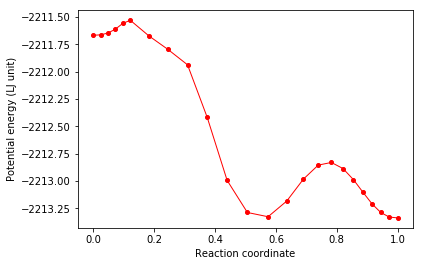

In [10]:
plt.plot(x,y,'ro',linestyle='solid', linewidth=1, markersize=4)
plt.xlabel("Reaction coordinate")
plt.ylabel("Potential energy (LJ unit)")
plt.show()

In [11]:
# Forward and Reverse enegy barrier
print("Index of maximum energy image =",np.argmax(y))
print("Forward energy barrier =",df['EBF'][1])
print("Reverse energy barrier =",df['EBR'][1])

Index of maximum energy image = 5
Forward energy barrier = 0.13973715
Reverse energy barrier = 1.8111218


## Visualize MEP (movie)

In [12]:
%%capture
# Use ffmpeg to make mp4 movie
!cat *.jpg | ffmpeg -y -f image2pipe -c:v mjpeg -i - -b:v 2000k -vcodec libx264 -pix_fmt yuv420p neb.mp4;

In [13]:
%%HTML
<video width="320" height="320" controls>
  <source src="neb.mp4?2" type="video/mp4">
</video>